In [5]:
!pip install -q kaleido


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import kaleido, sys, importlib, pkg_resources
print("kaleido version:", pkg_resources.get_distribution("kaleido").version)

ModuleNotFoundError: No module named 'kaleido'

In [6]:
# Cell 1 – imports & helper
import pandas as pd, numpy as np
import plotly.express as px
from geopy.distance import geodesic
from pathlib import Path

DATA = Path("../data")
FIGS = Path("../figs"); FIGS.mkdir(exist_ok=True)

def gc_km(a, b):
    """Great-circle distance in km between two (lat, lon) tuples."""
    return geodesic(a, b).km

In [7]:
# Cell 2 – load detections, isolate same tag used in notebook A
det = pd.read_csv(DATA / "blue_shark_detections.csv",
                  parse_dates=["datecollected"])
det.rename(columns={"datecollected": "timestamp"}, inplace=True)

tag_id = det.tagname.value_counts().idxmax()      # same logic as before
fish   = det[det.tagname == tag_id].copy()

print(f"{len(fish)} detections for tag {tag_id}")

526 detections for tag A69-9001-24395


In [8]:
# Cell 3 – counts per receiver + distance calculation
# pick the 'reference' receiver = one with most detections
top_rx        = (fish.station.value_counts().idxmax())
top_lat, top_lon = (fish.loc[fish.station == top_rx,
                             ["latitude", "longitude"]]
                         .iloc[0])

# detections per receiver
counts = (fish.groupby("station")
                .agg(n=("station", "size"),
                     lat=("latitude", "first"),
                     lon=("longitude", "first"))
                .reset_index())

# efficiency as fraction of the best receiver
best_n                = counts.n.max()
counts["eff"]         = counts.n / best_n

# distance (km) from reference receiver
counts["dist_km"] = counts.apply(
    lambda r: gc_km((top_lat, top_lon), (r.lat, r.lon)),
    axis=1
)

# tidy for plotting
curve = counts.sort_values("dist_km")[["dist_km", "eff"]]

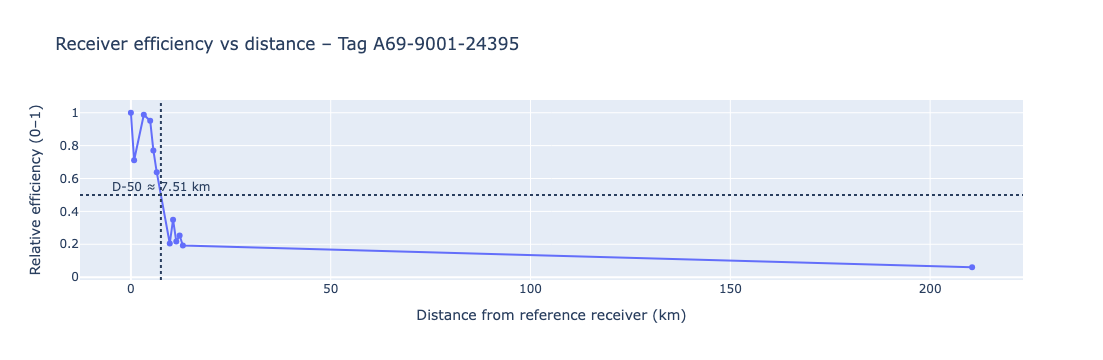

D-50 ≈ 7.51 km – curve saved to figs/


In [14]:
# Cell 4 – Plotly line + D-50 annotation
import plotly.express as px
fig = px.line(curve, x="dist_km", y="eff", markers=True,
              labels=dict(dist_km="Distance from reference receiver (km)",
                          eff="Relative efficiency (0–1)"),
              title=f"Receiver efficiency vs distance – Tag {tag_id}")

# approximate D-50 (linear interpolation on sorted data)
d50 = np.interp(0.5, curve.eff[::-1], curve.dist_km[::-1])
fig.add_hline(y=0.5, line_dash="dot")
fig.add_vline(x=d50, line_dash="dot")
fig.add_annotation(x=d50, y=0.55,
                   text=f"D-50 ≈ {d50:.2f} km",
                   showarrow=False)

fig.show()

# save outputs for the dashboard
# fig.write_image(FIGS / f"eff_curve_{tag_id}.png", scale=2)
# px.io.write_html(FIGS / f"eff_curve_{tag_id}.png", scale=2)
fig.update_layout(template=None)
fig.write_json(FIGS / f"eff_curve_{tag_id}.json")
print(f"D-50 ≈ {d50:.2f} km – curve saved to figs/")